<a href="https://colab.research.google.com/github/AMonLer/Swiss-Co.-Valuation/blob/main/DCF_Python_Lindt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DCF Company Valuation in Python - Chocoladefabriken Lindt & Sprüngli AG**


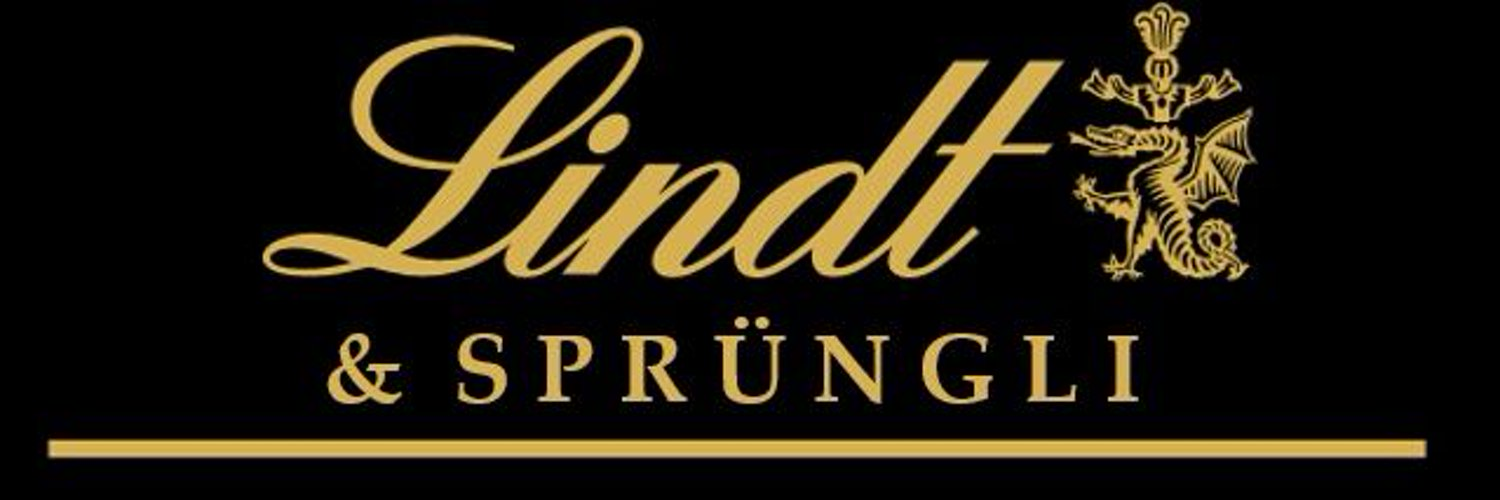

In [2]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats
import sys
import openturns as ot
from IPython.display import display

pd.options.display.max_columns=1000
pd.options.display.max_rows= 200
pd.options.display.float_format = '{:,.3f}'.format

In [ ]:
! pip list

### Valuation functions


In [3]:
def dynamic_converger(current,
                      expected,
                      number_of_steps,
                      period_to_begin_to_converge):
    """This Function is to project growth in 2 phase.
    Phase 1: You grow  Period after period for number of period specified.
    Phase 2: growth begin to converge to number_of_steps value.
    current: begining growth_rate
    expected: final growth rate
    period_to_begin_to_converge: Period to begin to transition to terminal growth value
    number_of_steps: number of period (years) to project growth."""
    number_of_steps =  int(number_of_steps)
    period_to_begin_to_converge = int(period_to_begin_to_converge)
    def converger(current,
                expected,
                number_of_steps):
        values = np.linspace(current,expected,number_of_steps+1)
        return(values)

    array_phase1 = np.array([current]*(period_to_begin_to_converge-1))

    array_phase2 = converger(current,
                       expected,
                       number_of_steps-period_to_begin_to_converge)
    result= pd.Series(np.concatenate((array_phase1,array_phase2)))
    return(result)

In [4]:
def dynamic_converger_multiple_phase(growth_rates_for_each_cylce,
                                     length_of_each_cylce,
                                     convergance_periods):
    list_of_results = []
    for cycle in range(len(length_of_each_cylce)):
        result = dynamic_converger(current = growth_rates_for_each_cylce[cycle][0],
                        expected = growth_rates_for_each_cylce[cycle][1],
                        number_of_steps = length_of_each_cylce[cycle],
                        period_to_begin_to_converge = convergance_periods[cycle])
        list_of_results.append(result)
    return(pd.concat(list_of_results,ignore_index=True))


def revenue_projector_multi_phase(revenue_base,
                                  revenue_growth_rate_cycle1_begin,
                                  revenue_growth_rate_cycle1_end,
                                  revenue_growth_rate_cycle2_begin,
                                  revenue_growth_rate_cycle2_end,
                                  revenue_growth_rate_cycle3_begin,
                                  revenue_growth_rate_cycle3_end = 0.028,
                                  length_of_cylcle1=3,
                                  length_of_cylcle2=4,
                                  length_of_cylcle3=3,
                                  revenue_convergance_periods_cycle1 =1,
                                  revenue_convergance_periods_cycle2=1,
                                  revenue_convergance_periods_cycle3=1):
    projected_revenue_growth = dynamic_converger_multiple_phase(growth_rates_for_each_cylce= [[revenue_growth_rate_cycle1_begin,revenue_growth_rate_cycle1_end],
                                                               [revenue_growth_rate_cycle2_begin,revenue_growth_rate_cycle2_end],
                                                               [revenue_growth_rate_cycle3_begin,revenue_growth_rate_cycle3_end]],
                                     length_of_each_cylce=[length_of_cylcle1,length_of_cylcle2,length_of_cylcle3],
                                     convergance_periods=[revenue_convergance_periods_cycle1,
                                                          revenue_convergance_periods_cycle2,
                                                          revenue_convergance_periods_cycle3])
    ### Compute Cummulative revenue_growth
    projected_revenue_growth_cumulative = (1+projected_revenue_growth).cumprod()
    projected_revneues = revenue_base*projected_revenue_growth_cumulative
    return(projected_revneues,projected_revenue_growth)

In [5]:
def operating_margin_projector(current_operating_margin,
                               terminal_operating_margin,
                               valuation_interval_in_years=10,
                               year_operating_margin_begins_to_converge_to_terminal_operating_margin=5):
    projectd_operating_margin = dynamic_converger(current_operating_margin,
                                                  terminal_operating_margin,
                                                  valuation_interval_in_years,
                                                  year_operating_margin_begins_to_converge_to_terminal_operating_margin)
    return(projectd_operating_margin)

In [6]:
def tax_rate_projector(current_effective_tax_rate,
                      marginal_tax_rate,
                      valuation_interval_in_years=10,
                      year_effective_tax_rate_begin_to_converge_marginal_tax_rate=5):
    """Project tax rate during valuation Cylce"""
    projected_tax_rate = dynamic_converger(current_effective_tax_rate,
                                           marginal_tax_rate,
                                           valuation_interval_in_years,
                                           year_effective_tax_rate_begin_to_converge_marginal_tax_rate)
    return(projected_tax_rate)

In [7]:
def cost_of_capital_projector(unlevered_beta,
                              terminal_unlevered_beta,
                              current_pretax_cost_of_debt,
                              terminal_pretax_cost_of_debt,
                              equity_value,
                              debt_value,
                              marginal_tax_rate=.21,
                              risk_free_rate=0.015,
                              ERP=0.055,
                              valuation_interval_in_years=10,
                              year_beta_begins_to_converge_to_terminal_beta=5,
                              year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt=5):
    """Project Cost of Capiatal during valuation Cylce"""
    ### Compute Beta During Valuatio Cycle
    ### Company Levered Beta  = Unlevered beta * (1 + (1- tax rate) (Debt/Equity))
    company_beta = unlevered_beta * (1+(1-marginal_tax_rate)*(debt_value/equity_value))
    terminal_beta = terminal_unlevered_beta * (1+(1-marginal_tax_rate)*(debt_value/equity_value))
    beta_druing_valution_cycle = dynamic_converger(company_beta,
                                                   terminal_beta,
                                                   valuation_interval_in_years,
                                                   year_beta_begins_to_converge_to_terminal_beta)
    ### Compute Pre Tax Cost Of debt During Valuation Cycle
    pre_tax_cost_of_debt_during_valution_cycle = dynamic_converger(current_pretax_cost_of_debt,
                                                                   terminal_pretax_cost_of_debt,
                                                                   valuation_interval_in_years,
                                                                   year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt)

    total_capital = equity_value+debt_value
    equity_to_capital = equity_value/total_capital
    debt_to_capital = debt_value/total_capital
    after_tax_cost_of_debt_during_valution_cycle = pre_tax_cost_of_debt_during_valution_cycle*(1-marginal_tax_rate)
    cost_of_equity = risk_free_rate + (beta_druing_valution_cycle*ERP)
    cost_of_capital_during_valuatio_cycle = ((equity_to_capital*cost_of_equity)+
                                             (debt_to_capital*after_tax_cost_of_debt_during_valution_cycle))
    return(cost_of_capital_during_valuatio_cycle,beta_druing_valution_cycle,terminal_beta,cost_of_equity,after_tax_cost_of_debt_during_valution_cycle)

In [8]:
def revenue_growth_projector(revenue_growth_rate,
                             terminal_growth_rate=.028,
                             valuation_interval_in_years=10,
                             year_revenue_growth_begin_to_converge_to_terminal_growth_rate = 5):
    """Project revenue growth during valuation Cylce"""
    projected_revenue_growth = dynamic_converger(revenue_growth_rate,
                                                 terminal_growth_rate,
                                                 valuation_interval_in_years,
                                                 year_revenue_growth_begin_to_converge_to_terminal_growth_rate)
    return(projected_revenue_growth)

In [9]:
def revenue_projector(revenue_base,
                      revenue_growth_rate,
                      terminal_growth_rate,
                      valuation_interval_in_years,
                      year_revenue_growth_begin_to_converge_to_terminal_growth_rate):
    ### Estimate Revenue Growth
    projected_revenue_growth = revenue_growth_projector(revenue_growth_rate=revenue_growth_rate,
                                                        terminal_growth_rate = terminal_growth_rate,
                                                        valuation_interval_in_years=valuation_interval_in_years,
                                                        year_revenue_growth_begin_to_converge_to_terminal_growth_rate=year_revenue_growth_begin_to_converge_to_terminal_growth_rate)
    ### Compute Cummulative revenue_growth
    projected_revenue_growth_cumulative = (1+projected_revenue_growth).cumprod()
    projected_revneues = revenue_base*projected_revenue_growth_cumulative
    return(projected_revneues,projected_revenue_growth)

In [10]:
def sales_to_capital_projector(current_sales_to_capital_ratio,
                               terminal_sales_to_capital_ratio,
                               valuation_interval_in_years=10,
                               year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital=3):
    projectd_sales_to_capiatl = dynamic_converger(current_sales_to_capital_ratio,
                                                  terminal_sales_to_capital_ratio,
                                                  valuation_interval_in_years,
                                                  year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital)
    return(projectd_sales_to_capiatl)

In [11]:
def reinvestment_projector(revenue_base,
                           projected_revneues,
                           sales_to_capital_ratios,
                           asset_liquidation_during_negative_growth=0):
    reinvestment = (pd.concat([pd.Series(revenue_base),
                               projected_revneues],
                             ignore_index=False).diff().dropna()/sales_to_capital_ratios)
    reinvestment = reinvestment.where(reinvestment>0, (reinvestment*asset_liquidation_during_negative_growth))
    return(reinvestment)

# Valuator

In [12]:
def valuator_multi_phase(
    risk_free_rate,
    ERP,
    equity_value,
    debt_value,
    unlevered_beta,
    terminal_unlevered_beta,
    year_beta_begins_to_converge_to_terminal_beta,
    current_pretax_cost_of_debt,
    terminal_pretax_cost_of_debt,
    year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt,
    current_effective_tax_rate,
    marginal_tax_rate,
    year_effective_tax_rate_begin_to_converge_marginal_tax_rate,
    revenue_base,
    revenue_growth_rate_cycle1_begin,
    revenue_growth_rate_cycle1_end,
    revenue_growth_rate_cycle2_begin,
    revenue_growth_rate_cycle2_end,
    revenue_growth_rate_cycle3_begin,
    revenue_growth_rate_cycle3_end,
    revenue_convergance_periods_cycle1,
    revenue_convergance_periods_cycle2,
    revenue_convergance_periods_cycle3,
    length_of_cylcle1,
    length_of_cylcle2,
    length_of_cylcle3,
    current_sales_to_capital_ratio,
    terminal_sales_to_capital_ratio,
    year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital,
    current_operating_margin,
    terminal_operating_margin,
    year_operating_margin_begins_to_converge_to_terminal_operating_margin,
    additional_return_on_cost_of_capital_in_perpetuity=0.0,
    cash_and_non_operating_asset=0.0,
    asset_liquidation_during_negative_growth=0,
    current_invested_capital='implicit'):
    """
    Value business with 3 cycles

    Parameters
    ----------
    risk_free_rate : riks free rate in the dominated currency you perform the D.C.F - if USD, then 10 year T Bond is a decent proxy

    ERP: Equity Risk Premium - How much investors are expecting to earn on stocks in excess of holidng risk free assest such as treasuries,

    equity_value: Estimate Equity value of the business. This is used to estiamte Weighted Average Cost of Capital aka WACC,

    debt_value: Market value or Book value of debt in the business,

    unlevered_beta : current unlevered beta (beta adjusted for debt - leverage) of the industry

    terminal_unlevered_beta: terminal unlevered beta (beta adjusted for debt - leverage) of the industry
    if valuing a frim in new space such as AI or Metaverse, intuitively you should have high beta (high risk profile) today, but in 10 years the beta should decrease as the space is more known and business matures

    year_beta_begins_to_converge_to_terminal_beta: The year which the convergence between unlevered_beta and terminal_unlevered_beta will begin to materialize

    current_pretax_cost_of_debt : Cost of rasing fresh debt - pre tax (the model takes interst expense deduction into account)

    terminal_pretax_cost_of_debt : Cost of rasing fresh debt - pre tax (the model takes interst expense deduction into account) at maturity

    year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt : The year which the convergence between current_pretax_cost_of_debt  and terminal_pretax_cost_of_debt will begin to materialize

    current_effective_tax_rate : Effecive tax rate, can be found on the income statement

    marginal_tax_rate : Marginal Tax rate of your company - for mature companies effective tax rate should be close or equal to marginal_tax_rate

    year_effective_tax_rate_begin_to_converge_marginal_tax_rate : The year which the convergence between current_effective_tax_rate and marginal_tax_rate will begin to materialize

    revenue_base: Current TTM revenue or normalized revenue - whatever you think is appropriate as your base revenue

    revenue_growth_rate_cycle1_begin : revenue growth rate at the begining of the 1st cycle

    revenue_growth_rate_cycle1_end : revenue growth rate at the end of the 1st cycle

    revenue_growth_rate_cycle2_begin : revenue growth rate at the begining of the 2nd cycle

    revenue_growth_rate_cycle2_end : revenue growth rate at the end of the 1st cycle

    revenue_growth_rate_cycle3_begin : revenue growth rate at the begining of the 3rd cycle

    revenue_growth_rate_cycle3_end : revenue growth rate at the end of the 3rd cycle - aka Terminal growth rate - should not exceed your risk free rate

    revenue_convergance_periods_cycle1 : The year which the convergence between revenue_growth_rate_cycle1_begin and revenue_growth_rate_cycle1_end will begin to materialize

    revenue_convergance_periods_cycle2 : The year which the convergence between revenue_growth_rate_cycle2_begin and revenue_growth_rate_cycle2_end will begin to materialize

    revenue_convergance_periods_cycle3 : The year which the convergence between revenue_growth_rate_cycle3_begin and revenue_growth_rate_cycle3_end will begin to materialize

    length_of_cylcle1 : number of years that cycle 1 will last

    length_of_cylcle2 : number of years that cycle 2 will last

    length_of_cylcle3 : number of years that cycle 3 will last

    current_sales_to_capital_ratio : estimated reinvestment based upon the change in revenues and the sales to capital ratio
    Reinvestmentt = Change in revenuest/ (Sales/Capital)
    assuming a sales to capital ratio of 2.5, in conjunction with a revenue increase of $ 250 million will result in reinvestment of $ 100 million

    terminal_sales_to_capital_ratio : terminal sales to capital ratio

    year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital : The year which the convergence between current_sales_to_capital_ratio and terminal_sales_to_capital_ratio will begin to materialize

    current_operating_margin : TTM to normalized ebit margin (operating margin)

    terminal_operating_margin : Terminal operating margin - should be close to industry average - might possibly be higher or lower than industry average if your company has demostrate lower or higher than average quality in earning and reinvetment etc.

    year_operating_margin_begins_to_converge_to_terminal_operating_margin: The year which the convergence between current_operating_margin and terminal_operating_margin will begin to materialize

    additional_return_on_cost_of_capital_in_perpetuity: Reinvestment rate in mature phase is required to keep the operating going - if your firm is able to earn higher than their cost of capital - which is rare -
    enter your estimated  excess return on capital in perpetuity

    cash_and_non_operating_asset : non operating investment as cash, such as holding in other companies, treasuries etc,

    asset_liquidation_during_negative_growth: If your bussines is declining as you are selling assets, how many % relative to your sales to capital ration you earn

    current_invested_capital : current value of deployed capital (asset in place) should include tangible and intangible

    """
    valuation_interval_in_years = int(length_of_cylcle1) + int(length_of_cylcle2) + int(length_of_cylcle3)
    terminal_growth_rate = revenue_growth_rate_cycle3_end
    ### Estimate Cost of Capital during the valution cycle
    projected_cost_of_capital, projected_beta , terminal_beta , projected_cost_of_equity , projected_after_tax_cost_of_debt = cost_of_capital_projector(unlevered_beta=unlevered_beta,
                                                          terminal_unlevered_beta=terminal_unlevered_beta,
                                                          current_pretax_cost_of_debt=current_pretax_cost_of_debt,
                                                          terminal_pretax_cost_of_debt=terminal_pretax_cost_of_debt,
                                                          equity_value=equity_value,
                                                          debt_value=debt_value,
                                                          marginal_tax_rate=marginal_tax_rate,
                                                          risk_free_rate=risk_free_rate,
                                                          ERP=ERP,
                                                          valuation_interval_in_years=valuation_interval_in_years,
                                                          year_beta_begins_to_converge_to_terminal_beta=year_beta_begins_to_converge_to_terminal_beta,
                                                          year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt=year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt)
    projected_cost_of_capital_cumulative= (1+projected_cost_of_capital).cumprod()
    projected_cost_of_equity_cumulative= (1+projected_cost_of_equity).cumprod()
    ### Estimate Future revnues, and growth

    projected_revneues,projected_revenue_growth = revenue_projector_multi_phase(revenue_base = revenue_base,
                                  revenue_growth_rate_cycle1_begin = revenue_growth_rate_cycle1_begin,
                                  revenue_growth_rate_cycle1_end = revenue_growth_rate_cycle1_end,
                                  revenue_growth_rate_cycle2_begin = revenue_growth_rate_cycle2_begin,
                                  revenue_growth_rate_cycle2_end = revenue_growth_rate_cycle2_end,
                                  revenue_growth_rate_cycle3_begin = revenue_growth_rate_cycle3_begin,
                                  revenue_growth_rate_cycle3_end = revenue_growth_rate_cycle3_end,
                                  length_of_cylcle1=length_of_cylcle1,
                                  length_of_cylcle2=length_of_cylcle2,
                                  length_of_cylcle3=length_of_cylcle3,
                                  revenue_convergance_periods_cycle1 = revenue_convergance_periods_cycle1,
                                  revenue_convergance_periods_cycle2 = revenue_convergance_periods_cycle2,
                                  revenue_convergance_periods_cycle3 = revenue_convergance_periods_cycle3)
    ### Estmimate tax rates
    projected_tax_rates = tax_rate_projector(current_effective_tax_rate=current_effective_tax_rate,
                                            marginal_tax_rate=marginal_tax_rate,
                                            valuation_interval_in_years=valuation_interval_in_years,
                                            year_effective_tax_rate_begin_to_converge_marginal_tax_rate=year_effective_tax_rate_begin_to_converge_marginal_tax_rate)
    ### Estimate slaes to capital ratio during valuation for reinvestment
    sales_to_capital_ratios = sales_to_capital_projector(current_sales_to_capital_ratio,
                               terminal_sales_to_capital_ratio,
                               valuation_interval_in_years=valuation_interval_in_years,
                               year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital=year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital)

    ### Estimate Reinvestemnt
    projected_reinvestment = reinvestment_projector(revenue_base=revenue_base,
                                                    projected_revneues = projected_revneues,
                                                    sales_to_capital_ratios=sales_to_capital_ratios,
                                                    asset_liquidation_during_negative_growth=asset_liquidation_during_negative_growth)

    ### Estimate invested Capital
    invested_capital = projected_reinvestment.copy()
    if current_invested_capital == 'implicit':
        current_invested_capital = revenue_base / current_sales_to_capital_ratio
    invested_capital[0] = invested_capital[0] + current_invested_capital
    invested_capital = invested_capital.cumsum()

    ### Operating Margin
    projected_operating_margins = operating_margin_projector(current_operating_margin,
                                                            terminal_operating_margin,
                                                            valuation_interval_in_years=valuation_interval_in_years,
                                                            year_operating_margin_begins_to_converge_to_terminal_operating_margin=year_operating_margin_begins_to_converge_to_terminal_operating_margin)
    ###EBIT
    projected_operating_income = projected_revneues * projected_operating_margins
    ### After Tax EBIT (EBI)
    projected_operating_income_after_tax = (projected_operating_income*(1-projected_tax_rates))
    ### FCFF: EBI-Reinvestment
    projected_FCFF = projected_operating_income_after_tax - projected_reinvestment
    ### compute ROIC
    ROIC = (projected_operating_income_after_tax/invested_capital)
    ### Compute Terminal Value
    terminal_cost_of_capital = projected_cost_of_capital[-1:].values
    terminal_cost_of_equity = projected_cost_of_equity[-1:].values
    if terminal_growth_rate < 0:
        terminal_reinvestment_rate=0
    else:
        terminal_reinvestment_rate = terminal_growth_rate/(terminal_cost_of_capital+additional_return_on_cost_of_capital_in_perpetuity)
    terminal_revenue = projected_revneues[-1:].values * (1+terminal_growth_rate)
    terminal_operating_income = terminal_revenue * terminal_operating_margin
    terminal_operating_income_after_tax = terminal_operating_income*(1-marginal_tax_rate)
    terminal_reinvestment = terminal_operating_income_after_tax* terminal_reinvestment_rate
    terminal_FCFF = terminal_operating_income_after_tax - terminal_reinvestment
    terminal_value = terminal_FCFF/(terminal_cost_of_capital-terminal_growth_rate)
    termimal_discount_rate = (terminal_cost_of_capital-terminal_growth_rate)*(1+projected_cost_of_capital).prod()
    termimal_equity_discount_rate = (terminal_cost_of_equity-terminal_growth_rate)*(1+projected_cost_of_equity).prod()


    ### Concatinate Projected Values with termianl values
    projected_cost_of_capital_cumulative_with_terminal_rate =pd.concat([projected_cost_of_capital_cumulative,
                                                    pd.Series(termimal_discount_rate)])
    projected_cost_of_equity_cumulative_with_terminal_rate = pd.concat([projected_cost_of_equity_cumulative,
                                                    pd.Series(termimal_equity_discount_rate)])

    projected_revenue_growth = pd.concat([projected_revenue_growth,
                                        pd.Series(terminal_growth_rate)])
    projected_revneues =pd.concat([projected_revneues,
                                  pd.Series(terminal_revenue)])
    projected_tax_rates = pd.concat([projected_tax_rates,
                                   pd.Series(marginal_tax_rate)])
    projected_reinvestment = pd.concat([projected_reinvestment,
                                        pd.Series(terminal_reinvestment)])


    ### Estimate invested Capital
    invested_capital = pd.concat([invested_capital,
                                        pd.Series(np.NaN)])
    ### Estimate ROIC
    terminal_ROIC = terminal_cost_of_capital+additional_return_on_cost_of_capital_in_perpetuity
    ROIC = pd.concat([ROIC,
                      pd.Series(terminal_ROIC)])

    projected_operating_margins = pd.concat([projected_operating_margins,
                                        pd.Series(terminal_operating_margin)])
    projected_operating_income = pd.concat([projected_operating_income,
                                            pd.Series(terminal_operating_income)])
    projected_operating_income_after_tax = pd.concat([projected_operating_income_after_tax,
                                                      pd.Series(terminal_operating_income_after_tax)])
    projected_FCFF_value = pd.concat([projected_FCFF,
                                      pd.Series(terminal_value)])

    projected_FCFF = pd.concat([projected_FCFF,
                                pd.Series(terminal_FCFF)])

    projected_beta = pd.concat([projected_beta,
                                pd.Series(terminal_beta)])

    sales_to_capital_ratios = pd.concat([sales_to_capital_ratios,
                                pd.Series([terminal_sales_to_capital_ratio])])

    ### Add terminal cost of debt to the terminal year
    projected_after_tax_cost_of_debt_with_terminal = pd.concat([projected_after_tax_cost_of_debt,
                                                                pd.Series(projected_after_tax_cost_of_debt[-1:].values)])

    reinvestmentRate = projected_reinvestment/projected_operating_income_after_tax

    df_valuation = df_valuation = pd.DataFrame({"cumWACC":projected_cost_of_capital_cumulative_with_terminal_rate,
                                 "cumCostOfEquity":projected_cost_of_equity_cumulative_with_terminal_rate,
                                'beta':projected_beta,
                                 'ERP':ERP,
                                 'projected_after_tax_cost_of_debt':projected_after_tax_cost_of_debt_with_terminal,
                                'revenueGrowth':projected_revenue_growth,
                                "revneues":projected_revneues,
                                 "margins":projected_operating_margins,
                                 'ebit':projected_operating_income,
                                 "sales_to_capital_ratio":sales_to_capital_ratios,
                                "taxRate":projected_tax_rates,
                               'afterTaxOperatingIncome':projected_operating_income_after_tax,
                               "reinvestment":projected_reinvestment,
                               "invested_capital":invested_capital,
                               "ROIC":ROIC,
                               'reinvestmentRate':reinvestmentRate,
                               'FCFF':projected_FCFF,
                               'projected_FCFF_value':projected_FCFF_value})
    #### Add reinvestment rate and expected growth rate
    df_valuation['PVFCFF'] = df_valuation['FCFF']/df_valuation['cumWACC']
    value_of_operating_assets = df_valuation['PVFCFF'].sum()
    firm_value =  pd.Series(value_of_operating_assets + cash_and_non_operating_asset)[0]
    intrinsic_equity_present_value = firm_value - debt_value

    #### Future Frim, Debt and Equity Value
    cum_cost_of_debt_at_the_end_of_end_of_valuation =  (projected_after_tax_cost_of_debt+1).prod()
    cum_cost_of_capital_at_the_end_of_valuation =projected_cost_of_capital_cumulative[-1:].values[0]
    cum_cost_of_equity_at_the_end_of_valuation = projected_cost_of_equity_cumulative[-1:].values[0]

    ### FV Debt
    debt_future_value = cum_cost_of_debt_at_the_end_of_end_of_valuation * debt_value

    ### FV Frim
    firm_future_value = cum_cost_of_capital_at_the_end_of_valuation * cum_cost_of_capital_at_the_end_of_valuation

    ### FV Equity
    intrinsic_equity_future_value = intrinsic_equity_present_value * cum_cost_of_equity_at_the_end_of_valuation
    ## Returns
    def cum_return_calculator(value,
                            period,
                            append_nan=True):
        period = int(period)
        cum_return_series = pd.Series([1+value]*period).cumprod()
        if append_nan:
            cum_return_series = pd.concat([cum_return_series,pd.Series(np.NAN)])
        return(cum_return_series)

    acceptable_annualized_return_on_equity = ((cum_cost_of_equity_at_the_end_of_valuation)**(1/valuation_interval_in_years))-1
    expected_annualized_return_on_equity = ((intrinsic_equity_future_value/equity_value)**(1/valuation_interval_in_years))-1
    excess_annualized_return_on_equity = ((intrinsic_equity_present_value/equity_value)**(1/valuation_interval_in_years))-1
    total_excess_return_on_equity_during_valuation_cycle = (intrinsic_equity_present_value/equity_value)-1
    # print("acceptable_annualized_return_on_equity",acceptable_annualized_return_on_equity)
    # print("expected_annualized_return_on_equity",expected_annualized_return_on_equity)
    # print("excess_annualized_return_on_equity",excess_annualized_return_on_equity)
    # print("total_excess_return_on_equity_during_valuation_cycle",total_excess_return_on_equity_during_valuation_cycle)
    # print(pd.Series([1+acceptable_annualized_return_on_equity]*valuation_interval_in_years))
    cum_acceptable_annualized_return_on_equity = cum_return_calculator(value = acceptable_annualized_return_on_equity,
                                                                       period = valuation_interval_in_years,
                                                                       append_nan=True)
    cum_expected_annualized_return_on_equity = cum_return_calculator(value = expected_annualized_return_on_equity,
                                                                       period = valuation_interval_in_years,
                                                                       append_nan=True)
    cum_excess_annualized_return_on_equity = cum_return_calculator(value = excess_annualized_return_on_equity,
                                                                       period = valuation_interval_in_years,
                                                                       append_nan=True)
    df_valuation['cum_acceptable_annualized_return_on_equity'] = cum_acceptable_annualized_return_on_equity
    df_valuation['cum_expected_annualized_return_on_equity'] = cum_expected_annualized_return_on_equity
    df_valuation['cum_excess_annualized_return_on_equity'] = cum_excess_annualized_return_on_equity
    df_valuation['cum_excess_annualized_return_on_equity_realized'] = df_valuation['cum_expected_annualized_return_on_equity']/df_valuation['cumCostOfEquity']
    df_valuation['excess_annualized_return_on_equity'] = pd.concat([pd.Series([excess_annualized_return_on_equity]*int(valuation_interval_in_years)),pd.Series(np.NAN)])
    # print("valuation complete")
    return({'valuation':df_valuation,
            'firm_value':firm_value,
            'equity_value':intrinsic_equity_present_value,
            'cash_and_non_operating_asset':cash_and_non_operating_asset,
            'debt_value':debt_value,
            'value_of_operating_assets':value_of_operating_assets})

In [13]:
def point_estimate_describer(base_case_valuation):
    print('value of operating assets',np.round(base_case_valuation['value_of_operating_assets'],2),'\n',
        'cash and non operating asset',np.round(base_case_valuation['cash_and_non_operating_asset'],2),'\n',
        'debt value',np.round(base_case_valuation['debt_value'],2),'\n',
        'firm value',np.round(base_case_valuation['firm_value'],2),'\n',
        'Intrinsic Equity value',"${:.2f}".format(np.round(base_case_valuation['equity_value'],2)))
    df_valuation = base_case_valuation['valuation']
    df_valuation=  df_valuation.reset_index(drop=True)
    df_valuation['Year']= df_valuation.reset_index()['index']+1
    df_valuation.loc[df_valuation['Year'] == df_valuation['Year'].max(),"Year"] = 'Terminal'
    df_valuation= df_valuation.set_index("Year")
    return(df_valuation)

## Monte Carlo Simulation

In [14]:
def monte_carlo_valuator_multi_phase(
    risk_free_rate,
    ERP,
    equity_value,
    debt_value,
    unlevered_beta,
    terminal_unlevered_beta,
    year_beta_begins_to_converge_to_terminal_beta,
    current_pretax_cost_of_debt,
    terminal_pretax_cost_of_debt,
    year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt,
    current_effective_tax_rate,
    marginal_tax_rate,
    year_effective_tax_rate_begin_to_converge_marginal_tax_rate,
     revenue_base,
     revenue_growth_rate_cycle1_begin,
     revenue_growth_rate_cycle1_end,
     revenue_growth_rate_cycle2_begin,
     revenue_growth_rate_cycle2_end,
     revenue_growth_rate_cycle3_begin,
     revenue_growth_rate_cycle3_end,
    revenue_convergance_periods_cycle1,
    revenue_convergance_periods_cycle2,
    revenue_convergance_periods_cycle3,
    length_of_cylcle1,
    length_of_cylcle2,
    length_of_cylcle3,
    current_sales_to_capital_ratio,
    terminal_sales_to_capital_ratio,
    year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital,
    current_operating_margin,
    terminal_operating_margin,
    year_operating_margin_begins_to_converge_to_terminal_operating_margin,
    additional_return_on_cost_of_capital_in_perpetuity,
    cash_and_non_operating_asset,
    asset_liquidation_during_negative_growth,
    current_invested_capital,
    sample_size=1000,
    list_of_correlation_between_variables=[['additional_return_on_cost_of_capital_in_perpetuity','terminal_sales_to_capital_ratio',0.4],
                                           ['additional_return_on_cost_of_capital_in_perpetuity','terminal_operating_margin',.6]]):
    variables_distributsion = [risk_free_rate,
                                   ERP,
                                   equity_value,
                                   debt_value,
                                   unlevered_beta,
                                    terminal_unlevered_beta,
                                    year_beta_begins_to_converge_to_terminal_beta,
                                    current_pretax_cost_of_debt,
                                    terminal_pretax_cost_of_debt,
                                    year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt,
                                    current_effective_tax_rate,
                                    marginal_tax_rate,
                                    year_effective_tax_rate_begin_to_converge_marginal_tax_rate,
                                    revenue_base,
                                    revenue_growth_rate_cycle1_begin,
                                    revenue_growth_rate_cycle1_end,
                                    revenue_growth_rate_cycle2_begin,
                                    revenue_growth_rate_cycle2_end,
                                    revenue_growth_rate_cycle3_begin,
                                    revenue_growth_rate_cycle3_end,
                                    revenue_convergance_periods_cycle1,
                                    revenue_convergance_periods_cycle2,
                                    revenue_convergance_periods_cycle3,
                                    length_of_cylcle1,
                                    length_of_cylcle2,
                                    length_of_cylcle3,
                                    current_sales_to_capital_ratio,
                                    terminal_sales_to_capital_ratio,
                                    year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital,
                                    current_operating_margin,
                                    terminal_operating_margin,
                                    year_operating_margin_begins_to_converge_to_terminal_operating_margin,
                                    additional_return_on_cost_of_capital_in_perpetuity,
                                    cash_and_non_operating_asset,
                                    asset_liquidation_during_negative_growth,
                                    current_invested_capital]
    variable_names = ['risk_free_rate',
                                   'ERP',
                                   'equity_value',
                                   'debt_value',
                                   'unlevered_beta',
                                    'terminal_unlevered_beta',
                                    'year_beta_begins_to_converge_to_terminal_beta',
                                    'current_pretax_cost_of_debt',
                                    'terminal_pretax_cost_of_debt',
                                    'year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt',
                                    'current_effective_tax_rate',
                                    'marginal_tax_rate',
                                    'year_effective_tax_rate_begin_to_converge_marginal_tax_rate',
                                    'revenue_base',
                                    'revenue_growth_rate_cycle1_begin',
                                    'revenue_growth_rate_cycle1_end',
                                    'revenue_growth_rate_cycle2_begin',
                                    'revenue_growth_rate_cycle2_end',
                                    'revenue_growth_rate_cycle3_begin',
                                    'revenue_growth_rate_cycle3_end',
                                    'revenue_convergance_periods_cycle1',
                                    'revenue_convergance_periods_cycle2',
                                    'revenue_convergance_periods_cycle3',
                                    'length_of_cylcle1',
                                    'length_of_cylcle2',
                                    'length_of_cylcle3',
                                    'current_sales_to_capital_ratio',
                                    'terminal_sales_to_capital_ratio',
                                    'year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital',
                                    'current_operating_margin',
                                    'terminal_operating_margin',
                                    'year_operating_margin_begins_to_converge_to_terminal_operating_margin',
                                    'additional_return_on_cost_of_capital_in_perpetuity',
                                    'cash_and_non_operating_asset',
                                    'asset_liquidation_during_negative_growth',
                                    'current_invested_capital']
    ### The following variable  should have "year" in their definition but I did not think of ut. So I am adding them to list_of_columns_with_year_to_be_int
    list_of_columns_with_year_to_be_int = [s for s in variable_names if "year" in s] +['length_of_cylcle1','length_of_cylcle2','length_of_cylcle3',
                                                                                       'revenue_convergance_periods_cycle1',
                                                                                       'revenue_convergance_periods_cycle2','revenue_convergance_periods_cycle3']
    ### Build a DataFarame to have index - location of each variable in the correlation matrix
    dict_of_varible = dict(zip(variable_names,
                            range(0,len(variable_names))))
    df_variables = pd.DataFrame([dict_of_varible])

    ### Initaile Correlation Matrix
    R = ot.CorrelationMatrix(len(variables_distributsion))
    ### pair correlation between each variable
    for pair_of_variable in list_of_correlation_between_variables:
        location = df_variables[pair_of_variable[:2]].values[0]
        #print(location)
        R[int(location[0]),int(location[1])] = pair_of_variable[2]

    ### Build the correlation into composed distribution function
    ### For ot.NormalCopula The correlation matrix must be definite positive
    ### Here is an implementaion on how to get the nearest psd matirx https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite
    copula = ot.NormalCopula(R)
    BuiltComposedDistribution = ot.ComposedDistribution(variables_distributsion,
                                                        copula)
    ### Generate samples
    generated_sample = BuiltComposedDistribution.getSample(sample_size)
    df_generated_sample = pd.DataFrame.from_records(generated_sample, columns= variable_names)
    df_generated_sample[list_of_columns_with_year_to_be_int] = df_generated_sample[list_of_columns_with_year_to_be_int].apply(lambda x: round(x))
    print("Scenario Generation Complete", df_generated_sample.shape)
    df_generated_sample['full_valuation']= df_generated_sample.apply(lambda row:
                                                                    valuator_multi_phase(
                                                                        risk_free_rate = row['risk_free_rate'],
                                                                        ERP = row['ERP'],
                                                                        equity_value = row['equity_value'],
                                                                        debt_value = row['debt_value'],
                                                                        unlevered_beta = row['unlevered_beta'],
                                                                        terminal_unlevered_beta = row['terminal_unlevered_beta'],
                                                                        year_beta_begins_to_converge_to_terminal_beta = row['year_beta_begins_to_converge_to_terminal_beta'],
                                                                        current_pretax_cost_of_debt = row['current_pretax_cost_of_debt'],
                                                                        terminal_pretax_cost_of_debt = row['terminal_pretax_cost_of_debt'],
                                                                        year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt = row['year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt'],
                                                                        current_effective_tax_rate = row['current_effective_tax_rate'],
                                                                        marginal_tax_rate = row['marginal_tax_rate'],
                                                                        year_effective_tax_rate_begin_to_converge_marginal_tax_rate = row['year_effective_tax_rate_begin_to_converge_marginal_tax_rate'],
                                                                        revenue_base = row['revenue_base'],
                                                                        revenue_growth_rate_cycle1_begin = row['revenue_growth_rate_cycle1_begin'],
                                                                        revenue_growth_rate_cycle1_end = row['revenue_growth_rate_cycle1_end'],
                                                                        revenue_growth_rate_cycle2_begin = row['revenue_growth_rate_cycle2_begin'],
                                                                        revenue_growth_rate_cycle2_end = row['revenue_growth_rate_cycle2_end'],
                                                                        revenue_growth_rate_cycle3_begin = row['revenue_growth_rate_cycle3_begin'],
                                                                        revenue_growth_rate_cycle3_end = row['revenue_growth_rate_cycle3_end'],
                                                                        revenue_convergance_periods_cycle1 = row['revenue_convergance_periods_cycle1'],
                                                                        revenue_convergance_periods_cycle2 = row['revenue_convergance_periods_cycle2'],
                                                                        revenue_convergance_periods_cycle3 = row['revenue_convergance_periods_cycle3'],
                                                                        length_of_cylcle1 = row['length_of_cylcle1'],
                                                                        length_of_cylcle2 = row['length_of_cylcle2'],
                                                                        length_of_cylcle3 = row['length_of_cylcle3'],
                                                                        current_sales_to_capital_ratio = row['current_sales_to_capital_ratio'],
                                                                        terminal_sales_to_capital_ratio = row['terminal_sales_to_capital_ratio'],
                                                                        year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital = row['year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital'],
                                                                        current_operating_margin = row['current_operating_margin'],
                                                                        terminal_operating_margin = row['terminal_operating_margin'],
                                                                        year_operating_margin_begins_to_converge_to_terminal_operating_margin = row['year_operating_margin_begins_to_converge_to_terminal_operating_margin'],
                                                                        additional_return_on_cost_of_capital_in_perpetuity = row['additional_return_on_cost_of_capital_in_perpetuity'],
                                                                        cash_and_non_operating_asset = row['cash_and_non_operating_asset'],
                                                                        asset_liquidation_during_negative_growth=row['asset_liquidation_during_negative_growth'],
                                                                        current_invested_capital=row['current_invested_capital']),
                                                                        axis=1)
    ### extract the valuation result
    df_generated_sample['valuation'] = df_generated_sample['full_valuation'].apply(lambda x: x['valuation'])
    df_generated_sample['equity_valuation'] = df_generated_sample['full_valuation'].apply(lambda x: x['equity_value'])
    df_generated_sample['firm_valuation'] = df_generated_sample['full_valuation'].apply(lambda x: x['firm_value'])
    df_generated_sample['terminal_revenue'] = df_generated_sample['valuation'].apply(lambda x: x['revneues'].values[-1])
    df_generated_sample['terminal_operating_margin'] = df_generated_sample['valuation'].apply(lambda x: x['margins'].values[-1])
    df_generated_sample['terminal_reinvestmentRate'] = df_generated_sample['valuation'].apply(lambda x: x['reinvestmentRate'].values[-1])
    df_generated_sample['terminal_afterTaxOperatingIncome'] = df_generated_sample['valuation'].apply(lambda x: x['afterTaxOperatingIncome'].values[-1])
    df_generated_sample['terminal_FCFF'] = df_generated_sample['valuation'].apply(lambda x: x['FCFF'].values[-1])
    df_generated_sample['cumWACC'] = df_generated_sample['valuation'].apply(lambda x: x['cumWACC'][:-1].values)
    df_generated_sample['cumCostOfEquity'] = df_generated_sample['valuation'].apply(lambda x: x['cumCostOfEquity'][:-1].values)
    df_generated_sample['cum_acceptable_annualized_return_on_equity'] = df_generated_sample['valuation'].apply(lambda x: x['cum_acceptable_annualized_return_on_equity'][:-1].values)
    df_generated_sample['cum_expected_annualized_return_on_equity'] = df_generated_sample['valuation'].apply(lambda x: x['cum_expected_annualized_return_on_equity'][:-1].values)
    df_generated_sample['cum_excess_annualized_return_on_equity'] = df_generated_sample['valuation'].apply(lambda x: x['cum_excess_annualized_return_on_equity'][:-1].values)
    df_generated_sample['cum_excess_annualized_return_on_equity_realized'] = df_generated_sample['valuation'].apply(lambda x: x['cum_excess_annualized_return_on_equity_realized'][:-1].values)
    df_generated_sample['excess_annualized_return_on_equity'] = df_generated_sample['valuation'].apply(lambda x: x['excess_annualized_return_on_equity'][:-1].values)
    df_generated_sample['ROIC'] = df_generated_sample['valuation'].apply(lambda x: x['ROIC'][:-1].values)
    df_generated_sample['invested_capital'] = df_generated_sample['valuation'].apply(lambda x: x['invested_capital'][:-1].values)
    return(df_generated_sample)

### Plotly Charts

In [15]:
def histogram_plotter_plotly(data,
                              colmn_name,
                              xlabel,
                              title='Data',
                              bins=30,
                              percentile=[15,50,85],
                              color=['green','yellow','red'],
                              histnorm='percent',
                              marginal=None,
                              height=470,
                              width=670):
    """Plot Historgam via Plotly"""
    fig = px.histogram(data,
                       x=colmn_name,
                       histnorm=histnorm,
                       nbins=bins,
                       labels={colmn_name:xlabel},
                       marginal=marginal)
    ### Make an educated guess on the y_max for line on the historgram
    n, bin_edges = np.histogram(data[colmn_name],bins=bins,density=False)
    bin_probability = n/float(n.sum())
    y_max = np.max(n/(n.sum())*100) *1.65
    ### Ad trace of percentiles
    for i in range(len(percentile)):
        fig = fig.add_trace(go.Scatter(x=[np.percentile(data[colmn_name],percentile[i]), np.percentile(data[colmn_name],percentile[i])],
                                       y=(0,y_max),
                                       mode="lines",
                                       name= str(percentile[i])+' Percentile',
                                       marker=dict(color=color[i])))
        #fig = fig.add_vline(x = np.percentile(data[colmn_name],percentile[i]), line_dash = 'dash',line_color=color[i])
        #print(str(percentile[i])+" Percentile",np.percentile(data[colmn_name],percentile[i]))
        fig.update_layout(height=height, width=width,title=title,
                          legend=dict(orientation="v"))
    return(fig)

def ecdf_plotter_plotly(data,
                              colmn_name,
                              xlabel,
                              title='Data',
                              percentile=[15,50,85],
                              color=['green','yellow','red'],
                              marginal=None,
                              height=500,
                              width=700):
    """Plot ECDF via Plotly"""
    fig = px.ecdf(data,
                     x=colmn_name,
                     labels={colmn_name:xlabel},
                     marginal=marginal)
    for i in range(len(percentile)):
        fig = fig.add_trace(go.Scatter(x=[np.percentile(data[colmn_name],percentile[i]), np.percentile(data[colmn_name],percentile[i])],
                                       y=(0,1),
                                       mode="lines",
                                       name= str(percentile[i])+' Percentile',
                                       marker=dict(color=color[i])))
        #fig = fig.add_vline(x = np.percentile(data[colmn_name],percentile[i]), line_dash = 'dash',line_color=color[i])
        #print(str(percentile[i])+" Percentile",np.percentile(data[colmn_name],percentile[i]))
        fig.update_layout(height=height, width=width,title=title,
                          legend=dict(orientation="v"))
    return(fig)

In [16]:
def time_series_plotly(df_data,
                       x,
                       yleft,
                       yright,
                       height=500,
                       width=1600,
                       title=None):
    """ Graph 2 time series on 2 different y-axis"""
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=df_data[x], y=df_data[yleft], name=yleft),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=df_data[x], y=df_data[yright], name=yright),
        secondary_y=True,
    )
    fig = fig.update_layout(height=height, width=width,title=title)
    return(fig)

def plotly_line_bar_chart(df_data,
                       x,
                       ybar,
                       yline,
                       height=500,
                       width=1600,
                       rangemode=None,
                       title=None):
    """ Graph 2 time series on 2 different y-axis"""
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    #fig.update_yaxes(rangemode='tozero')

    for bar_var in ybar:
        # Add traces
        fig.add_trace(
            go.Bar(x=df_data[x], y=df_data[bar_var],name=bar_var),
            secondary_y=False
            )
    #fig.update_yaxes(rangemode='tozero')
    for line_var in yline:
        fig.add_trace(
            go.Scatter(x=df_data[x], y=df_data[line_var],name=line_var),
            secondary_y=True,
            )
    if rangemode != None:
        fig.update_yaxes(rangemode=rangemode)
    fig = fig.update_layout(height=height, width=width,title=title)
    return(fig)


def plotly_line_dash_bar_chart(df_data,
                       x,
                       ybar,
                       yline,
                       ydash,
                       height=500,
                       width=1600,
                       rangemode=None,
                       title=None,
                       barmode='group',
                       texttemplate= "%{value}"
                       ):
    """ Graph 2 time series on 2 different y-axis"""
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    #fig.update_yaxes(rangemode='tozero')

    for bar_var in ybar:
        # Add traces
        fig.add_trace(
            go.Bar(x=df_data[x],
                   y=df_data[bar_var],
                   name=bar_var,
                   text = df_data[bar_var],
                   textposition="inside",
                   texttemplate= texttemplate,
                   textfont_color="white"),
            secondary_y=False,
            )
    for line_var in yline:
        fig.add_trace(
            go.Scatter(x=df_data[x],
                       y=df_data[line_var],
                       name=line_var
                       ),
            secondary_y=True,
            )

    for dash_var in ydash:
        fig.add_trace(
            go.Scatter(x=df_data[x],
                       y=df_data[dash_var],
                       name=dash_var,
                       line = dict(dash='dot')),
            secondary_y=True,
            )
    if rangemode != None:
        fig.update_yaxes(rangemode=rangemode)
    fig = fig.update_layout(height=height,
                            width=width,
                            title=title,
                            barmode=barmode)
    return(fig)

In [17]:
def line_plotter_with_error_bound(df_data,
                                  x,
                                  list_of_mid_point,
                                  list_of_lower_bound,
                                  list_of_upper_bound,
                                  list_of_bar=[],
                                  list_of_name=[],
                                  list_of_fillcolor= ['rgba(68, 68, 68, 0.3)'],
                                  list_of_line_color= ['rgb(31, 119, 180)'],
                                  title=None,
                                  yaxis_title=None,
                                  height=600,
                                  width=900):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    #fig.update_yaxes(rangemode='tozero')
    for mid_point,lower_bound,upper_bound,name,fillcolor,line_color in zip(list_of_mid_point,
                                                                            list_of_lower_bound,
                                                                            list_of_upper_bound,
                                                                            list_of_name,
                                                                            list_of_fillcolor,
                                                                            list_of_line_color):
        # Add traces
        fig.add_trace (
            go.Scatter(
                name = name,
                x=df_data[x],
                y=df_data[mid_point],
                mode='lines',
                line=dict(color=line_color)
                ))
        fig.add_trace(
            go.Scatter(
                name= name + ' UB',
                x = df_data[x],
                y = df_data[upper_bound],
                mode='lines',
                marker=dict(color=line_color),
                line=dict(width=0),
                showlegend=False
                ))
        fig.add_trace(
            go.Scatter(
        name= name + ' LB',
        x= df_data[x],
        y=df_data[lower_bound],
        marker=dict(color=line_color),
        line=dict(width=0),
        mode='lines',
        fillcolor= fillcolor,
        fill='tonexty',
        showlegend=False)
        )

    for bar_var in list_of_bar:
        fig.add_trace(
            go.Bar(x=df_data[x],
                   y=df_data[bar_var],
                   name=bar_var,
                   text = df_data[bar_var],
                   marker=dict(color='rgba(46, 120, 237,.6)'),
                   textposition="inside",
                   #texttemplate= texttemplate,
                   textfont_color="white"),
            secondary_y=True,
            )

    fig.update_layout(
        yaxis2=dict(
        side="right",
        #rangemode='tozero',
        range=[-.05, .3],
        #overlaying="y",
        #tickmode="sync"
        )
        )
    # fig.update_yaxes(rangemode='tozero')
    fig.update_layout(yaxis_title= yaxis_title,
                      title= title,
                      hovermode="x",
                      height=height,
                      width=width,)
    return(fig)

### Valuation Describer

In [18]:
def return_values_from_list_extractor(df_data,
                                        col,
                                        add_1=True):
    "This function is to get the cost stats of specied col by year"
    df_cost_of_cap = pd.DataFrame(list(df_data[col].values))
    if add_1:
        df_cost_of_cap[-1] = 1.00
    else:
        df_cost_of_cap[-1] = 0
    df_cost_of_cap = pd.melt(df_cost_of_cap,
                                var_name=['year'],
                                value_name=col).dropna()
    df_cost_of_cap = df_cost_of_cap.groupby(['year'])[[col]].describe().reset_index()
    df_cost_of_cap = data_frame_flattener(df_cost_of_cap)
    df_cost_of_cap = df_cost_of_cap.set_index("year")
    return(df_cost_of_cap)

def return_values_from_list_extractor_step2(df_data,
                                            cum_ret_col,
                                            ret_col):
    list_of_df_return = []
    for col in cum_ret_col:
        df_res = return_values_from_list_extractor(df_data,
                                                   col=col)
        list_of_df_return.append(df_res)
    for col in ret_col:
        df_res = return_values_from_list_extractor(df_data,
                                                   col=col,
                                                   add_1=False)
        list_of_df_return.append(df_res)
    df_returns = pd.concat(list_of_df_return,axis=1)
    df_returns = df_returns.reset_index(drop=True).reset_index().rename(columns={"index":"year"})
    return(df_returns)

In [19]:
def valuation_describer(df_intc_valuation,
                        sharesOutstanding=1):
    """Describe stats of monte dcf carlo simulation"""
    ### Get the Equity value at eahc percentile
    current_market_cap = df_intc_valuation['equity_value'].median()
    percentiles=np.arange(0, 110, 10)
    equity_value_at_each_percentile = np.percentile(df_intc_valuation['equity_valuation'],
                                                    percentiles)
    equity_value_at_20_percentile=equity_value_at_each_percentile[2]
    equity_value_at_80_percentile=equity_value_at_each_percentile[8]
    df_valuation_res = pd.DataFrame({"percentiles":percentiles,
                                     "equity_value":equity_value_at_each_percentile})
    df_valuation_res['current_market_cap'] = current_market_cap
    df_valuation_res['current_price_per_share'] = current_market_cap/sharesOutstanding
    df_valuation_res['equity_value_per_share'] = df_valuation_res['equity_value']/sharesOutstanding
    df_valuation_res['Price/Value']= df_valuation_res['current_market_cap']/df_valuation_res['equity_value']
    df_valuation_res['PNL']= (df_valuation_res['equity_value']/df_valuation_res['current_market_cap'])-1
    ### Histogram
    fig = histogram_plotter_plotly(data=df_intc_valuation,
                              colmn_name ='equity_valuation',
                              xlabel ='Market Cap',
                              title='Intrinsic Equity Value Distribution',
                              bins=200,
                              percentile=[15,50,85],
                              color=['green','yellow','red'],
                              histnorm='percent',
                              height=510,
                              width=720)
    fig = fig.add_vline(x = current_market_cap, line_dash = 'dash',line_color='black',
                        annotation_text="-Current Market Cap",
                        annotation_font_size=10)
    ### Plot cummultaive distribution of intrincsict equity value
    fig_cdf = ecdf_plotter_plotly(data=df_intc_valuation,
                              colmn_name ='equity_valuation',
                              xlabel ='Market Cap',
                              title='Intrinsic Equity Value Cumulative Distribution',
                              percentile=[15,50,85],
                              color=['green','yellow','red'],
                              marginal='histogram',
                              height=510,
                              width=720)
    fig_cdf = fig_cdf.add_vline(x = current_market_cap, line_dash = 'dash',line_color='black',annotation_text="-Current Market Cap", annotation_font_size=10)
    ### Model Correlation Chart
    fig_model_correlation_chart = px.bar(df_intc_valuation.rename(columns=dict(zip(df_intc_valuation.columns,
                                     [c.replace("_"," ") for c in df_intc_valuation.columns]))).corr(method='pearson')[['equity valuation']].sort_values(
                                         "equity valuation",ascending=False).reset_index(),
       x='index',
       y='equity valuation',
       title='Model Variable Pearson Correlation with Equity Intrinsic Value',
        height=730,
       width=1600,
       text_auto='.2f',
       labels={'index':'Model Variable',
               'equity valuation':'Correlation'})
    #### Return on Investment
    df_returns = return_values_from_list_extractor_step2(df_intc_valuation,
                                            cum_ret_col = ['cumWACC', 'cumCostOfEquity','cum_acceptable_annualized_return_on_equity','cum_expected_annualized_return_on_equity',
                                                           'cum_excess_annualized_return_on_equity','cum_excess_annualized_return_on_equity_realized'],
                                            ret_col=['excess_annualized_return_on_equity'])

    ### Plot returns
    fig_return = line_plotter_with_error_bound(df_data = df_returns,
                                  x='year',
                                  list_of_mid_point = ['cum_expected_annualized_return_on_equity 50%','cumCostOfEquity 50%'],
                                  list_of_lower_bound = ['cum_expected_annualized_return_on_equity min','cumCostOfEquity min'],
                                  list_of_upper_bound = ['cum_expected_annualized_return_on_equity max','cumCostOfEquity max'],
                                list_of_bar=['excess_annualized_return_on_equity 50%'],
                                  list_of_name=['Cum Expected Return','Cost of Equity'],
                                  list_of_fillcolor= ['rgba(59, 237, 157, 0.5)','rgba(255,84,167, 0.3)'],
                                  list_of_line_color= ['rgb(37, 162, 111)','rgb(238, 72, 103)'],
                                  title='Return on Equity Investment',
                                  yaxis_title='Cum Return',
                                  height=500,
                                  width=1400)
    #### ROIC and Invested Capital
    df_roic = return_values_from_list_extractor_step2(df_data = df_intc_valuation,
                                            cum_ret_col = [],
                                            ret_col = ['ROIC','invested_capital'])[1:]

    fig_roic_inv = plotly_line_dash_bar_chart(df_roic,
                       x='year',
                       ybar=['invested_capital 50%'],
                       yline=['ROIC 50%'],
                       ydash=[],
                       height=500,
                       width=1600,
                       rangemode=None,
                       title='Simulated Median ROIC and Invested Capital',
                       barmode='group',
                       #texttemplate= "%{value}"
                       ).update_layout(hovermode="x")


    fig_model_correlation_chart.show()
    fig_roic_inv.show()
    for col in ['revenue_growth_rate_cycle1_begin',
                'revenue_growth_rate_cycle1_end',
                'revenue_growth_rate_cycle2_begin',
                'revenue_growth_rate_cycle2_end',
                'revenue_growth_rate_cycle3_begin',
                'revenue_growth_rate_cycle3_end'
                'revenue_growth_rate',
                'risk_free_rate','ERP',
                'additional_return_on_cost_of_capital_in_perpetuity',
                'terminal_reinvestmentRate',
                'terminal_afterTaxOperatingIncome',
                'firm_valuation',
                'terminal_FCFF',
                'unlevered_beta',
                'terminal_unlevered_beta',
                'current_sales_to_capital_ratio',
                'terminal_sales_to_capital_ratio',
                'current_operating_margin',
                'terminal_operating_margin',
                'terminal_revenue']:
                try:
                    histogram_plotter_plotly(df_intc_valuation,
                                             colmn_name=col,
                                             xlabel=col.replace("_"," "),
                                             bins=200).show()
                except:
                    pass
    fig_cdf.show()
    fig.show()
    fig_return.show()
    return(df_valuation_res)

# DCF Example:

# Lindt and Sprüngli





### **Point Estimate Valuation**

#### **Narrative and Numbers**

1. Strong Brand: Lindt is a well-established and globally recognized brand in the premium chocolate and confectionery industry. Strong brand recognition can translate into customer loyalty and pricing power. We can see it this during this inflation environment

1. Market Position: Lindt holds a significant position in the premium chocolate market, and it has a history of consistent growth and innovation. This can be indicative of a company's
1. Operating margin will be expanded to around 10%.
1. Dividend Payments: It has increased over 1000 CHF per share  

In [20]:
base_case_valuation = valuator_multi_phase(
            risk_free_rate =.03,
            ERP = .034,
            equity_value = 23.016,
            debt_value = 1.587,
            cash_and_non_operating_asset= 0.756,
            unlevered_beta = .6,
            terminal_unlevered_beta = .6,
            year_beta_begins_to_converge_to_terminal_beta = 1,
            current_pretax_cost_of_debt =.04,
            terminal_pretax_cost_of_debt =.035,
            year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt = 3,
            current_effective_tax_rate = .24,
            marginal_tax_rate =.25,
            year_effective_tax_rate_begin_to_converge_marginal_tax_rate = 1,
             revenue_base = 5.048,
             revenue_growth_rate_cycle1_begin = .11,
             revenue_growth_rate_cycle1_end = .6,
             length_of_cylcle1 = 6,
             revenue_growth_rate_cycle2_begin = .5,
             revenue_growth_rate_cycle2_end = .04,
             length_of_cylcle2=6,
             revenue_growth_rate_cycle3_begin =.03,
             revenue_growth_rate_cycle3_end =.02,
             length_of_cylcle3=6,
            revenue_convergance_periods_cycle1= 1,
            revenue_convergance_periods_cycle2=1,
            revenue_convergance_periods_cycle3=1,
            current_sales_to_capital_ratio = 8.44,
            terminal_sales_to_capital_ratio = 8.22,
            year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital = 1,
            current_operating_margin = .15,
            terminal_operating_margin = .1,
            year_operating_margin_begins_to_converge_to_terminal_operating_margin = 1,
            additional_return_on_cost_of_capital_in_perpetuity= 0.02,
            asset_liquidation_during_negative_growth=0,
            current_invested_capital = 6.062)
point_estimate_describer(base_case_valuation)

value of operating assets 162.23 
 cash and non operating asset 0.76 
 debt value 1.59 
 firm value 162.99 
 Intrinsic Equity value $161.40


,cumWACC,cumCostOfEquity,beta,ERP,projected_after_tax_cost_of_debt,revenueGrowth,revneues,margins,ebit,sales_to_capital_ratio,taxRate,afterTaxOperatingIncome,reinvestment,invested_capital,ROIC,reinvestmentRate,FCFF,projected_FCFF_value,PVFCFF,cum_acceptable_annualized_return_on_equity,cum_expected_annualized_return_on_equity,cum_excess_annualized_return_on_equity,cum_excess_annualized_return_on_equity_realized,excess_annualized_return_on_equity
Year,,,,,,,,,,,,,,,,,,,,,,,,
1,1.050,1.051,0.631,0.034,0.030,0.110,5.603,0.150,0.840,8.440,0.240,0.639,0.066,6.128,0.104,0.103,0.573,0.573,0.546,1.051,1.172,1.114,1.114,0.114
2,1.103,1.106,0.631,0.034,0.030,0.208,6.769,0.147,0.995,8.427,0.241,0.756,0.138,6.266,0.121,0.183,0.618,0.618,0.560,1.106,1.373,1.242,1.242,0.114
3,1.158,1.162,0.631,0.034,0.030,0.306,8.840,0.144,1.274,8.414,0.241,0.967,0.246,6.512,0.148,0.255,0.721,0.721,0.622,1.162,1.608,1.384,1.384,0.114
4,1.216,1.222,0.631,0.034,0.030,0.404,12.411,0.141,1.752,8.401,0.242,1.329,0.425,6.937,0.192,0.320,0.903,0.903,0.743,1.222,1.884,1.542,1.542,0.114
5,1.277,1.285,0.631,0.034,0.029,0.502,18.642,0.138,2.577,8.388,0.242,1.952,0.743,7.680,0.254,0.380,1.210,1.210,0.948,1.285,2.208,1.718,1.718,0.114
6,1.341,1.351,0.631,0.034,0.029,0.600,29.827,0.135,4.035,8.375,0.243,3.055,1.335,9.016,0.339,0.437,1.720,1.720,1.283,1.351,2.586,1.914,1.914,0.114
7,1.408,1.421,0.631,0.034,0.029,0.500,44.740,0.132,5.922,8.362,0.244,4.479,1.783,10.799,0.415,0.398,2.696,2.696,1.915,1.421,3.030,2.133,2.133,0.114
8,1.478,1.494,0.631,0.034,0.029,0.408,62.995,0.129,8.152,8.349,0.244,6.162,2.186,12.985,0.475,0.355,3.976,3.976,2.690,1.494,3.550,2.377,2.377,0.114
9,1.552,1.571,0.631,0.034,0.028,0.316,82.901,0.126,10.485,8.336,0.245,7.919,2.388,15.373,0.515,0.302,5.531,5.531,3.564,1.571,4.160,2.648,2.648,0.114


### Monte Carlo DCF

### Lindt & Sprüngli Monte Carlo DCF Valuation

In [21]:
df_valuation = monte_carlo_valuator_multi_phase(
    risk_free_rate = ot.Normal(0.03,.002),
    ERP =  ot.Normal(0.034,.001) ,
    equity_value = ot.Triangular(20,23.016,26),
    debt_value = ot.Triangular(1.3,1.587,1.7),
    unlevered_beta = ot.Triangular(.7,.756,8),
    terminal_unlevered_beta = ot.Triangular(.7,.756,8),
    year_beta_begins_to_converge_to_terminal_beta = ot.Uniform(1,2),
    current_pretax_cost_of_debt = ot.Triangular(.057,.06,.063),
    terminal_pretax_cost_of_debt = ot.Triangular(.052,.055,.058),
    year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt = ot.Uniform(1,2),
    current_effective_tax_rate = ot.Triangular(.23,.24,.25),
    marginal_tax_rate = ot.Triangular(.23,.25,.27),
    year_effective_tax_rate_begin_to_converge_marginal_tax_rate = ot.Uniform(1,3),
     revenue_base = ot.Triangular(8.8,9.2,9.6),
     revenue_growth_rate_cycle1_begin = ot.Distribution(ot.SciPyDistribution(scipy.stats.skewnorm(-2.9, loc= .145, scale=.032))), ## high growth is priced in already, skewed towards left if there is any surprise, it's most likely bad
     revenue_growth_rate_cycle1_end = ot.Distribution(ot.SciPyDistribution(scipy.stats.skewnorm(-2.9, loc=.18, scale=.033))), ## high growth, skewed towards left if there is any surprise, it's most likely bad
     length_of_cylcle1 = ot.Uniform(4,8),
     revenue_growth_rate_cycle2_begin = ot.Distribution(ot.SciPyDistribution(scipy.stats.skewnorm(-2.9, loc= .165, scale=.034))), ## high growth, skewed towards left if there is any surprise, it's most likely bad
     revenue_growth_rate_cycle2_end = ot.Distribution(ot.SciPyDistribution(scipy.stats.skewnorm(-2.9, loc= .11, scale=.032))), ## high growth, skewed towards left if there is any surprise, it's most likely bad
     length_of_cylcle2 = ot.Uniform(4,8),
     revenue_growth_rate_cycle3_begin = ot.Distribution(ot.SciPyDistribution(scipy.stats.skewnorm(-2.9, loc=.09, scale=.024))), ## high growth, skewed towards left if there is any surprise, it's most likely bad
     revenue_growth_rate_cycle3_end = ot.Normal(0.04,.002),
     length_of_cylcle3 = ot.Uniform(4,8),
    revenue_convergance_periods_cycle1 = ot.Uniform(1,2),
    revenue_convergance_periods_cycle2 = ot.Uniform(1,2),
    revenue_convergance_periods_cycle3 = ot.Uniform(1,2),
    current_sales_to_capital_ratio = ot.Triangular(1.5,1.7,1.9),
    terminal_sales_to_capital_ratio = ot.Triangular(1.1,1.3,1.6),
    year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital = ot.Uniform(1,3),
    current_operating_margin = ot.Triangular(.145,.15,.155),
    terminal_operating_margin = ot.Triangular(.12,.175,.22),
    year_operating_margin_begins_to_converge_to_terminal_operating_margin = ot.Uniform(1,3),
    additional_return_on_cost_of_capital_in_perpetuity = ot.Triangular(0.0,0.02,0.035),
    cash_and_non_operating_asset = ot.Uniform(1.6,1.8),
    asset_liquidation_during_negative_growth = ot.Uniform(0,0.000000001),
    current_invested_capital = ot.Uniform(5.8,6.2),
    sample_size= 20000,
    list_of_correlation_between_variables=[#### Intuitive / common sense  correlations
                                           ['revenue_growth_rate_cycle3_end','risk_free_rate',.95],
                                           ['revenue_growth_rate_cycle3_end','terminal_pretax_cost_of_debt',.9],
                                           ['terminal_pretax_cost_of_debt','risk_free_rate',.9],
                                           ### valuation specific correlation
                                           ['ERP','revenue_growth_rate_cycle2_begin',.4],
                                           ['ERP','revenue_growth_rate_cycle2_end',.4],
                                           ['ERP','revenue_growth_rate_cycle3_begin',.4],
                                           ['additional_return_on_cost_of_capital_in_perpetuity','terminal_sales_to_capital_ratio',0.25],
                                           ['additional_return_on_cost_of_capital_in_perpetuity','terminal_operating_margin',.5],
                                           ['terminal_sales_to_capital_ratio','terminal_operating_margin',.3],
                                           ]
                                           )

Scenario Generation Complete (20000, 36)


#### Monte Carlo Output

In [22]:
df_valuation.tail()

,risk_free_rate,ERP,equity_value,debt_value,unlevered_beta,terminal_unlevered_beta,year_beta_begins_to_converge_to_terminal_beta,current_pretax_cost_of_debt,terminal_pretax_cost_of_debt,year_cost_of_debt_begins_to_converge_to_terminal_cost_of_debt,current_effective_tax_rate,marginal_tax_rate,year_effective_tax_rate_begin_to_converge_marginal_tax_rate,revenue_base,revenue_growth_rate_cycle1_begin,revenue_growth_rate_cycle1_end,revenue_growth_rate_cycle2_begin,revenue_growth_rate_cycle2_end,revenue_growth_rate_cycle3_begin,revenue_growth_rate_cycle3_end,revenue_convergance_periods_cycle1,revenue_convergance_periods_cycle2,revenue_convergance_periods_cycle3,length_of_cylcle1,length_of_cylcle2,length_of_cylcle3,current_sales_to_capital_ratio,terminal_sales_to_capital_ratio,year_sales_to_capital_begins_to_converge_to_terminal_sales_to_capital,current_operating_margin,terminal_operating_margin,year_operating_margin_begins_to_converge_to_terminal_operating_margin,additional_return_on_cost_of_capital_in_perpetuity,cash_and_non_operating_asset,asset_liquidation_during_negative_growth,current_invested_capital,full_valuation,valuation,equity_valuation,firm_valuation,terminal_revenue,terminal_reinvestmentRate,terminal_afterTaxOperatingIncome,terminal_FCFF,cumWACC,cumCostOfEquity,cum_acceptable_annualized_return_on_equity,cum_expected_annualized_return_on_equity,cum_excess_annualized_return_on_equity,cum_excess_annualized_return_on_equity_realized,excess_annualized_return_on_equity,ROIC,invested_capital
19995,0.039,0.049,49.106,3.879,0.869,0.970,1.000,0.060,0.056,2.000,0.248,0.240,2.000,9.127,0.139,0.146,0.155,0.106,0.079,0.040,2.000,2.000,2.000,6.000,4.000,8.000,1.717,1.455,1.000,0.147,0.159,1.000,0.013,1.731,0.000,6.106,"{'valuation': ['cumWACC', 'cumCostOfEquity', '...",cumWACC cumCostOfEquity beta ERP proj...,32.537,36.416,56.452,0.399,6.817,4.097,"[1.0814230045937623, 1.1697856226951326, 1.265...","[1.084265622878734, 1.1759672110689319, 1.2757...","[1.0868927579726677, 1.181335867333432, 1.2839...","[1.0623206965310892, 1.1285252622782984, 1.198...","[0.9773923772503446, 0.9552958591070798, 0.933...","[0.9797605624631159, 0.9596570819797692, 0.939...","[-0.022607622749655443, -0.022607622749655443,...","[0.1677058060322255, 0.1707558153529652, 0.173...","[6.843936974048158, 7.691384581300365, 8.67768..."
19996,0.040,0.050,56.215,3.952,0.868,0.905,1.000,0.060,0.055,2.000,0.240,0.237,2.000,8.856,0.113,0.157,0.161,0.082,0.085,0.039,2.000,2.000,2.000,5.000,5.000,6.000,1.744,1.277,2.000,0.148,0.172,3.000,0.008,1.703,0.000,6.017,"{'valuation': ['cumWACC', 'cumCostOfEquity', '...",cumWACC cumCostOfEquity beta ERP proj...,30.512,34.464,45.566,0.423,5.971,3.446,"[1.0828328775388423, 1.1726577662776645, 1.270...","[1.085448425894054, 1.1783385390031962, 1.2793...","[1.086417357898379, 1.1803026755428943, 1.2823...","[1.0457077520144789, 1.0935047026231748, 1.143...","[0.9625285756086862, 0.9264612588632863, 0.891...","[0.9633877824763145, 0.9280055488537396, 0.893...","[-0.03747142439131379, -0.03747142439131379, -...","[0.16827239872908967, 0.1707380637545562, 0.17...","[6.59076747875522, 7.2294428508153175, 8.04732..."
19997,0.042,0.045,51.170,3.983,0.969,0.920,1.000,0.060,0.057,1.000,0.245,0.241,1.000,9.003,0.113,0.152,0.101,0.033,0.081,0.042,1.000,2.000,2.000,7.000,7.000,5.000,1.757,1.233,2.000,0.150,0.175,3.000,0.012,1.786,0.000,6.031,"{'valuation': ['cumWACC', 'cumCostOfEquity', '...",cumWACC cumCostOfEquity beta ERP proj...,32.416,36.399,49.967,0.447,6.631,3.666,"[1.0843748554555186, 1.1757296768206664, 1.274...","[1.0873988371716488, 1.1822965734039554, 1.285...","[1.0862427141836226, 1.1799232341170032, 1.281...","[1.0604542162674135, 1.1245631447993343, 1.192...","[0.9762589911264993, 0.9530816177553302, 0.930...","[0.9752210320784241, 0.9511684040169375, 0.927...","[-0.023741008873500724, -0.023741008873500724,...","[0.17202285706851242, 0.17462917897780408, 0.1...","[6.609601215856993, 7.291240642997538, 8.11061..."
19998,0.041,0.0

In [ ]:
### pass the simulated DCF valuation to the valuation_describer describe
valuation_describer(df_valuation,
                    sharesOutstanding=.027589800)